# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
# imports
import numpy as np
import cv2
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from calibration import Calibration
from utils import *
import preprocessing
from lane_detection import *

In [2]:
# sample images
test_images = glob.glob('test_images/*.jpg')
project_images = glob.glob('test_images/video_samples/project*.jpg')
challange_images = glob.glob('test_images/video_samples/challange*.jpg')
harder_challange_images = glob.glob('test_images/video_samples/harder_challange*.jpg')

In [3]:
# settings
settings = preprocessing.MaskSetting()
settings.blur = 19
settings.grad_x = preprocessing.GradientSetting(9, (10,100))
settings.grad_y = preprocessing.GradientSetting(9, (10,100))
settings.grad_mag = preprocessing.GradientSetting(9, (10,100))

roi_src = np.array([[560,460], [190,690], [1150,690], [750,460]], dtype='float32')
roi_dst = np.array([[320, 0], [320,720], [960,720], [960, 0]], dtype='float32')

In [4]:
cal = Calibration(nx=9, ny=6)
cal.compute_cal('camera_cal/calibration*.jpg')
M, M_inv = preprocessing.get_prespective_transform(roi_src, roi_dst)

Loaded camera config from file: calibration.pkl


In [5]:
img = mpimg.imread(test_images[1])
# undistort
dst = cal.undistort(img)
# create binary mask
_,_,mask = preprocessing.gradient_mask(img, settings, 'and')
# roi
roi = preprocessing.roi(mask, roi_src)
# warp image
warped = preprocessing.warp_image(roi, M)

# lane detection
leftx, lefty, rightx, righty, leftx_base, rightx_base = find_lane_pixels(warped, nwindows=9, margin=100, minpix=50)

# meters per pixels
xm = 3.7/(rightx_base-leftx_base)
ym = 30/720

midpoint = get_offset(leftx_base,rightx_base,img.shape[1])*xm
left_fit = fit_polynomial(leftx, lefty)
right_fit = fit_polynomial(rightx, righty)
left_curvature = measure_curvature(719*ym, cvt_line_to_meters(left_fit, xm, ym))
right_curvature = measure_curvature(719*ym, cvt_line_to_meters(right_fit, xm, ym))

Lane offset: -0.10m
Curvature: 645.35,892.79


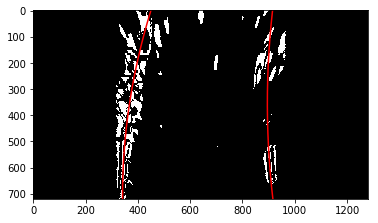

In [6]:
plot_ploy_lines(warped, left_fit, right_fit)
                                    
print('Lane offset: {:.2f}m'.format(midpoint))
print('Curvature: {:.2f},{:.2f}'.format(left_curvature, right_curvature))

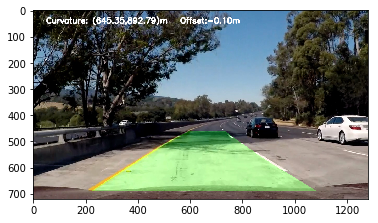

In [7]:
lane_image = draw_lanes(img, left_fit, right_fit, M_inv)
# Combine the result with the original image
result = cv2.addWeighted(img, 1, lane_image, 0.3, 0)
# display text
cv2.putText(result,
            'Curvature: ({:.2f},{:.2f})m   Offset:{:.2f}m'.format(left_curvature, right_curvature, midpoint),
            (50,50), cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),3,cv2.LINE_AA)
plt.imshow(result)

## Lane Detector Class

In [8]:
from LaneDetector import LaneDetection

settings = preprocessing.MaskSetting()
settings.blur = 19
settings.grad_x = preprocessing.GradientSetting(9, (10,100))
settings.grad_y = preprocessing.GradientSetting(9, (10,100))
settings.grad_mag = preprocessing.GradientSetting(9, (10,100))
roi_src = np.array([[560,460], [190,690], [1150,690], [750,460]], dtype='float32')
roi_dst = np.array([[320, 0], [320,720], [960,720], [960, 0]], dtype='float32')

detector = LaneDetection(roi_src, roi_dst, settings)

Loaded camera config from file: calibration.pkl


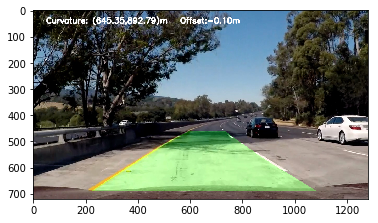

In [10]:
result = detector.process(img)
plt.imshow(result)

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [26]:
clip = VideoFileClip("test_videos/project_video.mp4")
output = clip.fl_image(detector.process)
output.write_videofile('output.mp4', audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


 49%|████▊     | 613/1261 [02:30<02:38,  4.10it/s]WARNING:py.warnings:/Users/rumman/Documents/udacity/sdc/CarND-Advanced-Lane-Lines/lane_detection.py:85: RankWarning: Polyfit may be poorly conditioned
  return np.polyfit(lefty, leftx, 2)

 49%|████▉     | 618/1261 [02:31<02:39,  4.03it/s]WARNING:py.warnings:/Users/rumman/Documents/udacity/sdc/CarND-Advanced-Lane-Lines/lane_detection.py:85: RankWarning: Polyfit may be poorly conditioned
  return np.polyfit(lefty, leftx, 2)

100%|█████████▉| 1260/1261 [05:07<00:00,  4.07it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 



In [28]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('output.mp4'))